(generalised_filtering)=
# Generalised Bayesian Filtering of exponential family distributions

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/0.3-Generalised_filtering.ipynb)

In [1]:
import sys

from IPython.utils import io

if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from scipy.stats import norm, t

from pyhgf.math import MultivariateNormal, Normal, gaussian_predictive_distribution
from pyhgf.model import Network

np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In this tutorial, we are interested in online Bayesian filtering when applied to [exponential family distributions](https://en.wikipedia.org/wiki/Exponential_family). Bayesian inference in high-dimensional space can rapidly become intractable, requiring approximation or sampling methods that always remain computationally costly. However exponential family distributions have interesting properties that allow expressing Bayesian updates through a simple closed-form solution over hyperparameters that is common to all family members. This property is well-described for stationary distributions and can extend to non-stationary distributions through the application of a fixed learning rate. But this solution can be further improved by dynamically learning the learning rate itself, which is something that Hierarchical Gaussian Filters are especially good at. 

Here, we leverage the approach described in {cite:p}`mathys:2020` to demonstrate that the Hierarchical Gaussian Filter can be generalized to any probability distribution that belongs to the [exponential family](https://en.wikipedia.org/wiki/Exponential_family). In this tutorial we will describe how to filter stationary and non-stationary distributions using a fixed learning rate or by using a predictive coding network on top of sufficient statistics elicited by new observations. This approach has the advantage of being extremely modular and flexible while extending dynamic Bayesian filtering to a whole range of models. This already underpins the {ref}`categorical_hgf`, in which case the implied distribution is a Dirichlet distribution.

## Theory

:::{hint} Exponential family distributions
Exponential family distributions are probability distributions which can be written in the form:
$$
p(x|\vartheta) = f_x(\vartheta) := h(x) exp(\eta(\vartheta) · t(x) − b(\vartheta))
$$
where:
- $x$ is a vector-valued observation
- $\vartheta$ is a parameter vector
- $h(x)$ is a normalization constant
- $\eta(\vartheta)$ is the natural parameter vector
- $t(x)$ is the sufficient statistic vector
- $b(\vartheta)$ is a scalar function
:::


It has been shown in {cite:p}`mathys:2020` that, when chosing as prior:

$$
p(\vartheta|\xi, \nu) = g_{\xi, \nu}(\vartheta) := z(\xi, \nu) \exp (\nu(\eta(\vartheta)·\xi−b(\vartheta)))
$$

with the variable

$$
z(\xi, \nu) := (\int \exp(\nu(\eta(\vartheta) · \xi−b(\vartheta)))d\vartheta)^{−1}
$$

as normalization constant, then the posterior is a simple update of the hyperparameters in the form:

$$
\begin{align*}
& \nu \leftarrow \nu + 1 \\
& \xi \leftarrow \xi + \frac{1}{\nu + 1}(t(x)-\xi)
\end{align*}
$$

## Filtering the Sufficient Statistics of a Stationary Distribution

We start applying this update steps to the estimation of the parameters from a stationary normal distribution.

In [3]:
x = np.arange(-7, 7, 0.01)  # x axis
xi, nu = np.array([0, 1 / 8]), 1.0  # initial hyperparameters
xs = np.random.normal(5, 1 / 4, 1000)  # input observations

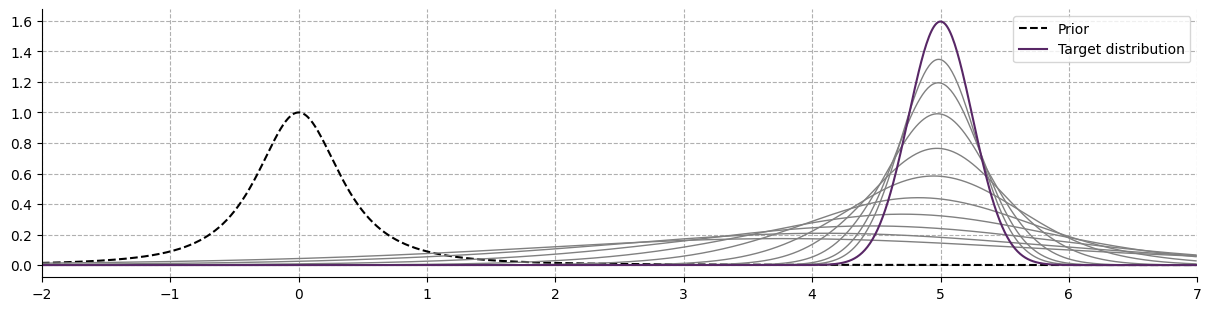

In [4]:
plt.figure(figsize=(12, 3))
plt.plot(
    x,
    gaussian_predictive_distribution(x, xi=xi, nu=nu),
    color="k",
    label="Prior",
    linestyle="--",
)
for i, x_i in enumerate(xs):
    xi = xi + (1 / (1 + nu)) * (
        Normal().sufficient_statistics_from_observations(x=x_i) - xi
    )
    nu += 1

    if i in [2, 4, 8, 16, 32, 64, 128, 256, 512, 999]:
        plt.plot(
            x,
            gaussian_predictive_distribution(x, xi=xi, nu=nu),
            color="grey",
            linewidth=1.0,
        )
plt.plot(
    x, norm.pdf(x, loc=5.0, scale=1 / 4), color="#582766", label="Target distribution"
)
plt.xlim(-2, 7)
plt.legend()
plt.grid(linestyle="--")
sns.despine()

The vizualisation of the predictive distribution over new observations require integrating the joint probability of the prior $g_{\xi, \nu}(\vartheta)$ and the posterior $f_x(\vartheta)$. In the case of a univariate normal, the *Gaussian-predictive* distribution is given by:

$$
\mathcal{NP}(x, \xi, \nu) := \sqrt{\frac{1}{\pi(\nu+1)(\xi_{x^2}-\xi_{x}^2)}}\frac{\Gamma(\frac{\nu+2}{2})}{\Gamma(\frac{\nu+1}{2})} \left( 1+\frac{(x-\xi_{x})^2}{(\nu+1)(\xi_{x^2}-\xi_x^2)} \right) ^{-\frac{\nu+2}{2}}
$$

When $\xi = 0, 1$, this corresponds to the Student's-t distribution with $\nu + 1$ degrees of freedom, as evidenced here:

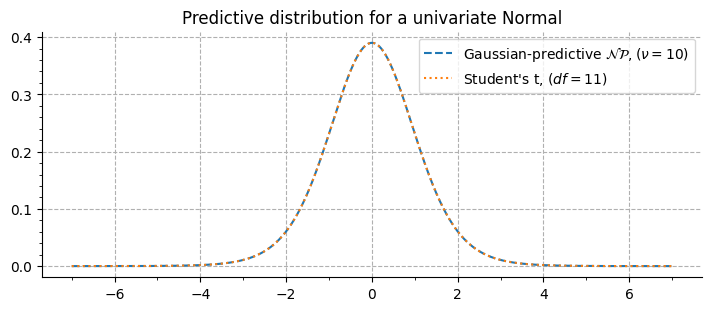

In [5]:
_, ax = plt.subplots(figsize=(7, 3))
ax.plot(
    x,
    gaussian_predictive_distribution(x, xi=np.array([0, 1]), nu=10),
    linestyle="--",
    label=r"Gaussian-predictive $\mathcal{NP}, (\nu = 10)$",
)

ax.plot(x, t.pdf(x, 11), linestyle=":", label=r"Student's t, $(df = 11)$")
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.02))
ax.set_title("Predictive distribution for a univariate Normal")
ax.legend()
ax.grid(linestyle="--")
sns.despine()

## Filtering the Sufficient Statistics of a Non-Stationary Distribution
Real-world applications of Bayesian filtering imply non-stationary distributions, in which cases the agent can no longer rely on distant observation and has to weigh down their evidence proportional to their distance from the current time point. In the current framework, this suggests that $\nu$, the pseudo-count vector, cannot linearly increase with the number of new observations but has to be limited. The most straightforward way is then to fix it to some values. Here, we start by applying this naive approach to a set of popular distributions, and then for each of them we illustrate how a collection of Hierarchical Gaussian Filters over sufficient statistics can help dynamic inference over the variable $\nu$ itself.

### Gaussian distribution

#### Generalised Bayesian Filtering: using a fixed $\nu$

This operation can be achieved using an exponential family state node, using the following parameters:
- Setting `kind="ef-state"`. We also set `learning="generalised-filtering"` to explicitly inform the node it should use the general filtering approach (using a fixed $\nu$)
- using a 1-dimensional Gaussian distribution by setting `distribution="normal"`
- using `nus=3.0`, this parameter will behave as the inverse of a learning rate, informing how much in the past we are looking to update the current sufficient statistics.
- setting `xis=np.array([0, 1 / 8])`, this is our starting point and first guess for the expected sufficient statistics.

Some of these steps were unnecessary, as this is the toolbox's default behaviour, but we added them here for clarity.

In [6]:
generalised_filter = Network().add_nodes(
    kind="ef-state", distribution="normal", nus=3.0, xis=np.array([0, 1 / 8])
)

:::{note} From sufficient statistics to distribution parameters and backwards
:class: dropdown

When using a 1-dimensional Gaussian distribution, Setting $\xi = [0, \frac{1}{8}]$ is equivalent to a mean $\mu = 0.0$ and a variance $\sigma^2 = \frac{1}{8}$. You can convert between distribution parameters and expected sufficient statistics using the distribution classes from PyHGF (when implemented):

```python
from pyhgf.math import Normal

# from an observation to sufficient statistics
Normal.sufficient_statistics_from_observations(x=1.5)
```
> Array([1.5 , 2.25], dtype=float32)

```python
# from distribution parameters to sufficient statistics
Normal.sufficient_statistics_from_parameters(mean=0.0, variance=4.0)
```
> Array([0., 4.], dtype=float32)

```python
# from sufficient statistics to distribution parameters
Normal.parameters_from_sufficient_statistics(xis=[0.0, 4.0])
```
> (0.0, 4.0)

:::

The resulting network consists in a single node that encapsulate all computation and do not depends on other nodes. Nodes supporting exponential family distribution can therefore support inputs of various shapes whithout requiring multiple input nodes.

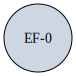

In [7]:
generalised_filter.plot_network()

We then create a time series to filter and pass it to the network using different values for the parameter $\nu$, representing how much past values should influence the Bayesian update.

In [8]:
x = np.arange(0, 1000)  # time points

# create noisy input time series with switching means
y = np.random.normal(0, 1 / 8, 1000)
y[200:400] += 0.5
y[600:800] -= 0.5

In [9]:
generalised_filter.input_data(input_data=y);

In [10]:
means, variances = [], []
nus = [3, 9, 35]
for nu in nus:

    # set a new learning rate
    generalised_filter.attributes[0]["nus"] = nu

    # fit to new data and convert the sufficient statistics into distribution parameters
    mean, variance = Normal.parameters_from_sufficient_statistics(
        xis=generalised_filter.input_data(input_data=y).node_trajectories[0]["xis"].T
    )

    # save distribution parameters    
    means.append(mean)
    variances.append(variance)

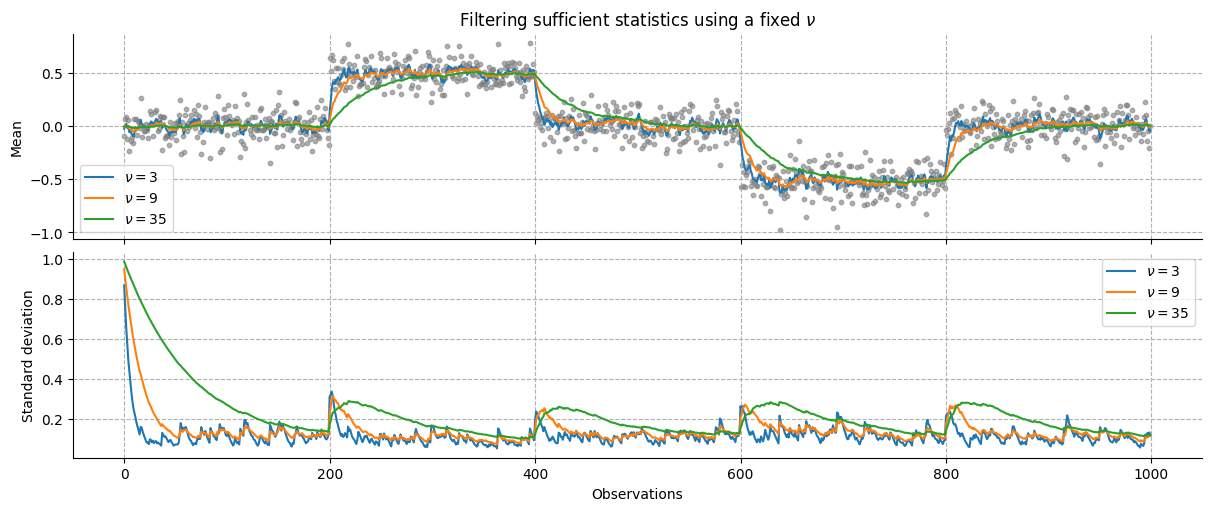

In [11]:
_, axs = plt.subplots(figsize=(12, 5), nrows=2, sharex=True)
axs[0].scatter(x, y, color="grey", alpha=0.6, s=10)
for mean, nu in zip(means, nus):
    axs[0].plot(x, mean, label=rf"$\nu = {nu}$")
axs[0].grid(linestyle="--")
axs[0].set_title(r"Filtering sufficient statistics using a fixed $\nu$")
axs[0].set_ylabel("Mean")
axs[0].legend()

for variance, nu in zip(variances, nus):
    axs[1].plot(x, jnp.sqrt(variance), label=rf"$\nu = {nu}$")
axs[1].grid(linestyle="--")
axs[1].set_xlabel("Observations")
axs[1].set_ylabel("Standard deviation")
axs[1].legend()

sns.despine()

We can see that larger values for $\nu$ correspond to a lower learning rate, and therefore smoother transition between states.

#### Using a dynamically adapted $\nu$ through a collection of Hierarchical Gaussian Filters

Limiting the number of past observations weighting in the predictive distribution comes with the difficult question of how to choose the correct value for such a parameter. Here, one solution to handle this is to let this parameter vary across time as a function of the volatility of the observations. Large unexpected variations should increase the learning rate, while limited, expected variations should increase the posterior precision. Interestingly, this is the kind of dynamic adaptation that reinforcement learning models are implementing, including the Hierarchical Gaussian Filter in this category. Here, we can derive the implied $\nu$ from a ratio of prediction and observation differentials such as:

$$
\nu \leftarrow \frac{\delta}{\Delta}
$$

with $\delta$ the prediction error at time $k$ and $\Delta$ the differential of expectations (before and after observing the new value).

In [12]:
univariate_hgf =  Network().add_nodes(kind="ef-state", learning="hgf-1")
univariate_hgf.attributes[1]["precision"] = 100.0
univariate_hgf.attributes[4]["precision"] = 100.0

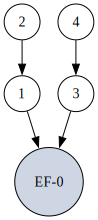

In [13]:
univariate_hgf.plot_network()

In [14]:
univariate_hgf.input_data(input_data=y);

In [15]:
# get the sufficient statistics from the first observation to parametrize the model
mean, variance = jnp.apply_along_axis(
    Normal().parameters_from_sufficient_statistics, 1, univariate_hgf.node_trajectories[0]["xis"]
)

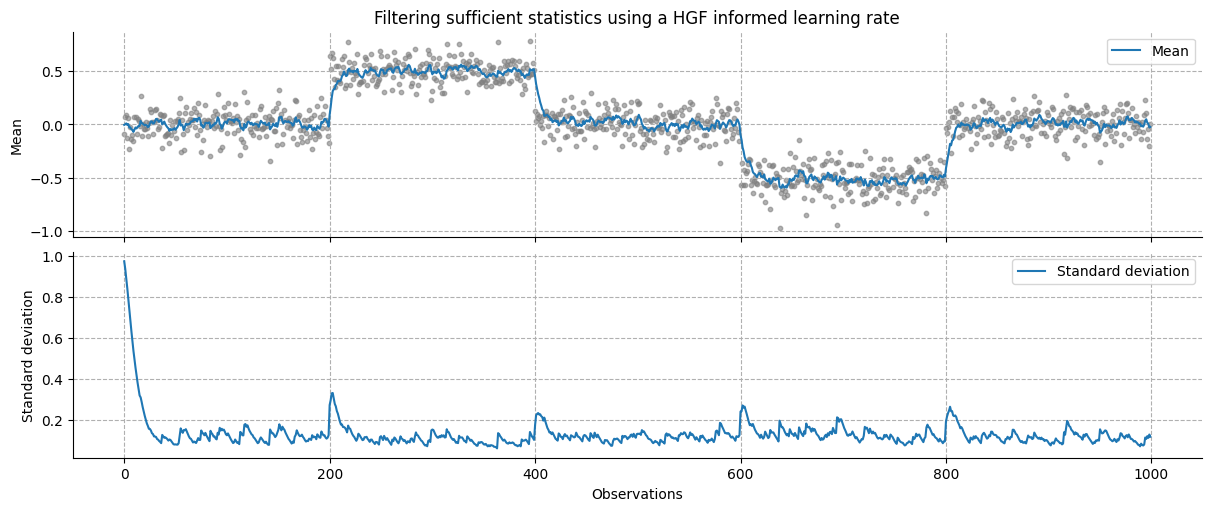

In [16]:
_, axs = plt.subplots(figsize=(12, 5), nrows=2, sharex=True)
axs[0].scatter(x, y, color="grey", alpha=0.6, s=10)
axs[0].plot(x, mean, label="Mean")
axs[0].grid(linestyle="--")
axs[0].set_title(r"Filtering sufficient statistics using a HGF informed learning rate")
axs[0].set_ylabel("Mean")
axs[0].legend()

axs[1].plot(x, jnp.sqrt(variance), label="Standard deviation")
axs[1].grid(linestyle="--")
axs[1].set_xlabel("Observations")
axs[1].set_ylabel("Standard deviation")
axs[1].legend()

sns.despine()

```{note}
In this model, each sufficient statistic is filtered separately, resulting in an implied learning rate for each of them. While this approach has the advantage of dynamically learning the various components of a distribution (see also how this can be done by value and volatility parents in the case of a continuous input {ref}`example_2`), this can result in invalid sufficient statistics (e.g. where the equality $\xi_1^2 = \xi_2$ does not hold anymore). Here, and in the rest of the examples, we simply average the learning rate to ensure consistent updating of the predictive distribution. 
```

### Multivariate Gaussian distribution

In [17]:
# simulate an ordered spiral data set
N = 1000
theta = np.sort(np.sqrt(np.random.rand(N)) * 5 * np.pi)
r_a = -2 * theta - np.pi
spiral_data = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T 
spiral_data += np.random.randn(N, 2) * .75 + np.random.randn(N, 2) * 1.5 * np.tile(np.repeat((0, 1, 0, 1, 0, 1, 0, 1, 0, 1), 100), (2, 1)).T

#### Generalised Bayesian Filtering: using a fixed $\nu$

In [18]:
bivariate_normal = Network().add_nodes(
    kind="ef-state", 
    nus=8.0,
    learning="generalised-filtering", 
    distribution="multivariate-normal", 
    dimension=2
).input_data(input_data=spiral_data)

In [19]:
# get the sufficient statistics from the first observation to parametrize the model
means, covariances = jnp.apply_along_axis(
    MultivariateNormal().parameters_from_sufficient_statistics, 1, bivariate_normal.node_trajectories[0]["xis"], dimension=2
)

```{figure} ../images/multivariate_normal.gif
---
name: multivariate-normal
---
The animation above displays the mean and covariance tracking of a bivariate normal distribution. The ellipse represents the 95% confidence interval of the covariance matrix. We can see that uncertainty is increasing in noisier sections of the distribution trajectory.
```

::::{note} Code to create this animation 👈
:class: dropdown

:::{code} python

from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from pyhgf.model import Network
import jax.numpy as jnp
from pyhgf.math import MultivariateNormal

# simulate an ordered spiral data set
N = 1000
theta = np.sort(np.sqrt(np.random.rand(N)) * 5 * np.pi)
r_a = -2 * theta - np.pi
spiral_data = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T 
spiral_data += np.random.randn(N, 2) * .75 + np.random.randn(N, 2) * 1.5 * np.tile(np.repeat((0, 1, 0, 1, 0, 1, 0, 1, 0, 1), 100), (2, 1)).T

bivariate_normal = Network().add_nodes(
    kind="ef-state", 
    nus=8.0,
    learning="generalised-filtering", 
    distribution="multivariate-normal", 
    dimension=2
).input_data(input_data=spiral_data)

# get the sufficient statistics from the first observation to parametrize the model
means, covariances = jnp.apply_along_axis(
    MultivariateNormal().parameters_from_sufficient_statistics, 1, bivariate_normal.node_trajectories[0]["xis"], dimension=2
)

def plot_confidence_intervals(mean, cov, confidence_level=.95, plot=True):
       
    # Chi-squared value for the confidence level
    chi2_val = chi2.ppf(confidence_level, df=2)
    scaling_factor = np.sqrt(chi2_val)
    
    # Eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Calculate the ellipse parameters
    width = 2 * scaling_factor * np.sqrt(eigenvalues[1])  # Semi-major axis
    height = 2 * scaling_factor * np.sqrt(eigenvalues[0])  # Semi-minor axis
    angle = np.degrees(np.arctan2(eigenvectors[1, 1], eigenvectors[0, 1]))  # Use the largest eigenvalue's eigenvector
    
    # Return the ellipse
    if plot:
        return Ellipse(xy=mean, width=width, height=height, angle=angle, alpha=.2, color="#c44e52")
    else:
        return mean, width, height, angle

fig, ax = plt.subplots(figsize=(5, 5))
scat = ax.scatter(
    spiral_data[0, 0],
    spiral_data[0, 1],
    edgecolor="k",
    alpha=0.4,
    s=10
)
scat2 = ax.scatter(
    means[0, 1],
    means[0, 0],
    edgecolor="#c44e52",
    s=25
)
plot = ax.plot(
    means[0, 1],
    means[0, 0],
    color="#c44e52",
    linestyle="--",
    label="Belief trajectory"
)[0]

# Confidence intervals
ellipse = plot_confidence_intervals(means[0, :], covariances[0, :])
ax.add_patch(ellipse)

ax.grid(linestyle="--")
ax.set(
    xlim=[-35, 35],
    ylim=[-35, 35],
    xlabel=r"$x_1$",
    ylabel=r"$x_2$",
    title=f"Bayesian Filtering \n of a Bivariate Stochastic Process",
)
plt.tight_layout()


def update(frame):
    frame *= 3
    # update the scatter plot
    data = np.stack([spiral_data[:frame, 0], spiral_data[:frame, 1]]).T
    scat.set_offsets(data)

    data2 = np.stack([means[frame, 0], means[frame, 1]]).T
    scat2.set_offsets(data2)

    # update the belief trajectory
    plot.set_ydata(means[:frame, 1])
    plot.set_xdata(means[:frame, 0])

    # update the confidence intervals
    mean, width, height, angle = plot_confidence_intervals(
        means[frame, :], covariances[frame, :], plot=False
    )
    ellipse.set_center(mean)
    ellipse.width = width
    ellipse.height = height
    ellipse.angle = angle

    return scat, scat2, plot, ellipse

ani = FuncAnimation(fig=fig, func=update, frames=333, interval=100)
ani.save("anim.gif")
:::

::::

#### Using a dynamically adapted $\nu$ through a collection of Hierarchical Gaussian Filters

Filtering the sufficient statistics of a two-dimensional multivariate normal distribution requires tracking the values of 5 parameters in parallel. Our model therefore consists of 5 independent two-level continuous HGF.

In [20]:
bivariate_hgf = Network().add_nodes(
    kind="ef-state", 
    learning="hgf-2", 
    distribution="multivariate-normal", 
    dimension=2
)

# adapting prior parameter values to the sufficient statistics
# covariances statistics will have greater variability and amplitudes
for node_idx in [2, 5, 8, 11, 14]:
    bivariate_hgf.attributes[node_idx]["tonic_volatility"] = -2.0
for node_idx in [1, 4, 7, 10, 13]:
    bivariate_hgf.attributes[node_idx]["precision"] = .01
for node_idx in [9, 12, 15]:
    bivariate_hgf.attributes[node_idx]["mean"] = 10.0

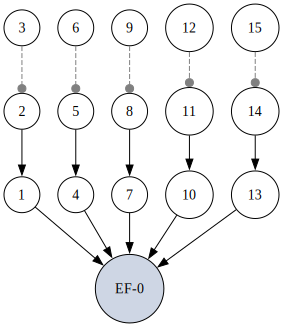

In [21]:
bivariate_hgf.plot_network()

In [22]:
bivariate_hgf.input_data(input_data=spiral_data);

In [23]:
# get the sufficient statistics
xis = jnp.apply_along_axis(
    MultivariateNormal().sufficient_statistics_from_observations, 1, spiral_data,
)

# System configuration

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Tue Aug 19 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 9.2.0

pyhgf : 0.2.7
jax   : 0.4.31
jaxlib: 0.4.31

pyhgf     : 0.2.7
seaborn   : 0.13.2
matplotlib: 3.10.1
numpy     : 2.2.5
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
IPython   : 9.2.0
jax       : 0.4.31

Watermark: 2.5.0

